<a href="https://colab.research.google.com/github/GoekeLab/sg-nex-data/blob/master/docs/SG_NEx_IsoTools_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcript reconstruction and quantification of SG-NEx samples with IsoTools

In this tutorial, we will introduce how to perform transcript reconstruction and quantification using [IsoTools](https://github.com/MatthiasLienhard/isotools) on the [Singapore Nanopore Expression Project (SG-NEx)](https://github.com/GoekeLab/sg-nex-data) samples. As an example, here we will be using six Nanopore direct RNA-Sequencing samples, three replicates from the A549 and HepG2 cell lines. The A549 cell line was extracted from lung tissues from a patient with lung cancer, whereas HepG2 was extracted from hepatocellular carcinoma from a patient with liver cancer.

The SG-NEx project is an international collaboration initiated at the Genome Institute of Singapore to provide reference transcriptomes for five of the most commonly used cancer cell lines, Hct116 (colon), K562 (leukocytes), HepG2 (liver), A549 (lung) and MCF7 (breast), using three different Nanopore long read RNA-Seq techonologies, PCR-cDNA sequencing ("PCR-cDNA"), amplification-free cDNA sequencing ("direct cDNA") and direct sequencing of native RNA (“direct RNA”), which is described in detail here: https://github.com/GoekeLab/sg-nex-data

For the analysis, we will use IsoTools, a python module for Long Read Transcriptome Sequencing (LRTS) analysis. Here we will show some key features of IsoTools, including transcript reconstruction and quantification, alternative splicing events classification, differential alternative splicing detection and data visualisation.<br>
GitHub repo of IsoTools can be found here: https://isotools.readthedocs.io/en/latest/tutorials.html<br>
A conprehensive tutorial about IsoTools is available here: https://isotools.readthedocs.io/en/latest/tutorials.html

## Table of Contents

- [IsoTools Installation](#isotools-installation)
- [Data download](#data-download)
- [Running software](#running-software)
- [Reference](#reference)

## IsoTools Installation

Isotools can be installed from PyPI, with the pip module. For installation, please run the following command:

In [1]:
!python -m pip install isotools

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier numpy>=1.16.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatrix or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier scipy>=1.2.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatrix or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier tables>=3.5.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatri

## Data download

The SG-NEx project has generated a comprehensive resource of long read RNA-Sequencing data using the Oxford Nanopore Sequencing third generation sequencing platform. The data is hosted on the [AWS Open Data Registry](https://registry.opendata.aws/sgnex/).

For this tutorial, we will be using a reduced data set which only includes data of two cell lines, HepG2 and A549, from the human chromosome 22. The data can be accessed using the AWS command line interface (or using direct links, which you can find in the online documentation).

### Install the AWS command line interface

In [2]:
! python -m pip install awscli

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier numpy>=1.16.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatrix or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier scipy>=1.2.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatrix or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: hicmatrix 15 has a non-standard dependency specifier tables>=3.5.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of hicmatri

In [3]:
! aws --version  

aws-cli/1.29.40 Python/3.10.12 Linux/5.15.94.mx64.447 botocore/1.31.40


In [4]:
! aws s3 ls --no-sign-request s3://sg-nex-data/data/data_tutorial/

                           PRE annotations/
                           PRE bam/
                           PRE fastq/


### Download the reference genome and annotations

In [5]:
! mkdir tutorial

! mkdir tutorial/reference

mkdir: cannot create directory ‘tutorial’: File exists
mkdir: cannot create directory ‘tutorial/reference’: File exists


In [6]:
# download reference genome

! aws s3 cp --no-sign-request s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.fa tutorial/reference/
! aws s3 cp --no-sign-request s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.fa.fai tutorial/reference/

download: s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.fa to tutorial/reference/hg38_chr22.fa
download: s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.fa.fai to tutorial/reference/hg38_chr22.fa.fai


In [7]:
# download reference annotations

! aws s3 cp --no-sign-request s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.gtf tutorial/reference/

download: s3://sg-nex-data/data/data_tutorial/annotations/hg38_chr22.gtf to tutorial/reference/hg38_chr22.gtf


### Download bam files

In [8]:
! mkdir tutorial/bam
! mkdir tutorial/isotools_results

mkdir: cannot create directory ‘tutorial/bam’: File exists
mkdir: cannot create directory ‘tutorial/isotools_results’: File exists


In [9]:
# download the example datasets

for celltype in ['HepG2', 'A549']:
    for method in ['directRNA']:
        for idx in range (1,4):
            ! aws s3 cp --no-sign-request s3://sg-nex-data/data/data_tutorial/bam/{celltype}_{method}_sample{idx}.bam tutorial/bam/
            ! aws s3 cp --no-sign-request s3://sg-nex-data/data/data_tutorial/bam/{celltype}_{method}_sample{idx}.bam.bai tutorial/bam/

download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample1.bam to tutorial/bam/HepG2_directRNA_sample1.bam
download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample1.bam.bai to tutorial/bam/HepG2_directRNA_sample1.bam.bai
download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample2.bam to tutorial/bam/HepG2_directRNA_sample2.bam
download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample2.bam.bai to tutorial/bam/HepG2_directRNA_sample2.bam.bai
download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample3.bam to tutorial/bam/HepG2_directRNA_sample3.bam
download: s3://sg-nex-data/data/data_tutorial/bam/HepG2_directRNA_sample3.bam.bai to tutorial/bam/HepG2_directRNA_sample3.bam.bai
download: s3://sg-nex-data/data/data_tutorial/bam/A549_directRNA_sample1.bam to tutorial/bam/A549_directRNA_sample1.bam
download: s3://sg-nex-data/data/data_tutorial/bam/A549_directRNA_sample1.bam.bai to tutorial/bam/A549_directRNA_sample1.bam.

## Running software

First, we need to load dependencies and set the path to the directory for this tutorial.

In [10]:
# preperation: import dependencies

from isotools import Transcriptome
from isotools import __version__ as isotools_version
import pandas as pd
import matplotlib.pyplot as plt
import logging

# set up logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isootools version {isotools_version}')

path='./tutorial/'

INFO:This is isootools version 0.3.4


### Import the reference annotation

For alignment, the reference annotation is necessary, which will be stored in the IsoTools transcriptome object as well.

In [11]:
annotation_fn=f'{path}/reference/hg38_chr22.gtf'

# create the IsoTools transcriptome object from the reference annotation
isoseq=Transcriptome.from_reference(annotation_fn)

INFO:importing reference from gtf file ./tutorial//reference/hg38_chr22.gtf
INFO:skipped the following categories: {'CDS', 'three_prime_utr', 'five_prime_utr', 'Selenocysteine'}


### Import the sequencing data

Next, we will need a table containing how to map samples to the corresponding sequencing data files.

In [12]:
# create a sample meatadata table to map samples and the corresponding data files

sample_names=[f'{cell_type}_{n+1}' for cell_type in ('A549', 'HepG2') for n in range(3)]
file_names=[f'{cell_type}_directRNA_sample{n+1}.bam' for cell_type in ('A549', 'HepG2') for n in range(3)]

samples=pd.DataFrame(dict(sample_name=sample_names, file_name=file_names, group=[sa.split('_')[0] for sa in sample_names]))

samples

,sample_name,file_name,group
0,A549_1,A549_directRNA_sample1.bam,A549
1,A549_2,A549_directRNA_sample2.bam,A549
2,A549_3,A549_directRNA_sample3.bam,A549
3,HepG2_1,HepG2_directRNA_sample1.bam,HepG2
4,HepG2_2,HepG2_directRNA_sample2.bam,HepG2
5,HepG2_3,HepG2_directRNA_sample3.bam,HepG2


Load the sequencing data files and count the number of imported reads.

In [13]:
# integrate the samples into the IsoTools transcriptome object

for i,row in samples.iterrows():
    # this step takes about 5-30 seconds per sample
     isoseq.add_sample_from_bam(path+'bam/'+row.file_name, sample_name=row.sample_name, group=row.group)

# the sample table of the transcriptome object contains the number of imported reads
isoseq.sample_table

INFO:adding sample A549_1 from file ./tutorial/bam/A549_directRNA_sample1.bam
100%|██████████████████| 12.2k/12.2k [00:04<00:00, 2.87kreads/s, chr=KI270394.1]
INFO:skipped 177 reads aligned fraction of less than 0.75.
INFO:skipped 5304 secondary alignments (0x100), alignment that failed quality check (0x200) or PCR duplicates (0x400)
INFO:ignoring 102 chimeric alignments with less than 2 reads
INFO:imported 6691 nonchimeric reads.
INFO:adding sample A549_2 from file ./tutorial/bam/A549_directRNA_sample2.bam
100%|██████████████████| 88.6k/88.6k [00:25<00:00, 3.52kreads/s, chr=KI270394.1]
INFO:skipped 3917 reads aligned fraction of less than 0.75.
INFO:skipped 30059 secondary alignments (0x100), alignment that failed quality check (0x200) or PCR duplicates (0x400)
INFO:ignoring 1214 chimeric alignments with less than 2 reads
INFO:imported 54022 nonchimeric reads (including  6 chained chimeric alignments).
INFO:adding sample A549_3 from file ./tutorial/bam/A549_directRNA_sample3.bam
100%|

,name,file,group,nonchimeric_reads,chimeric_reads
0,A549_1,./tutorial/bam/A549_directRNA_sample1.bam,A549,6691,0
0,A549_2,./tutorial/bam/A549_directRNA_sample2.bam,A549,54022,0
0,A549_3,./tutorial/bam/A549_directRNA_sample3.bam,A549,19594,0
0,HepG2_1,./tutorial/bam/HepG2_directRNA_sample1.bam,HepG2,21058,0
0,HepG2_2,./tutorial/bam/HepG2_directRNA_sample2.bam,HepG2,2822,0
0,HepG2_3,./tutorial/bam/HepG2_directRNA_sample3.bam,HepG2,1976,0


### Quality control

IsoTools has the functionality of quality control to detect possible technical artifacts. Based on quality metrics (and other properties), transcripts can get tagged, e.g. to indicate potential biases.

The default tags of technical artifacts including: internal priming, reverse transcriptase template switching (RTTS) and fragments.

In [14]:
genome_fn=f'{path}/reference/hg38_chr22.fa'

# compute quality control metrics
isoseq.add_qc_metrics(genome_fn)

100%|████████████████████████████████████| 1710/1710 [00:29<00:00, 58.75genes/s]


In [15]:
# statistic on the filter flags

# group specific
f_stats_groups=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    groups=isoseq.groups(),
    weight_by_coverage=True,
    min_coverage=2)

# sample specific
f_stats_samples=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    weight_by_coverage=True,
    min_coverage=2)

<Axes: title={'center': 'Expressed Transcripts > 2 reads'}, ylabel='fraction of reads'>

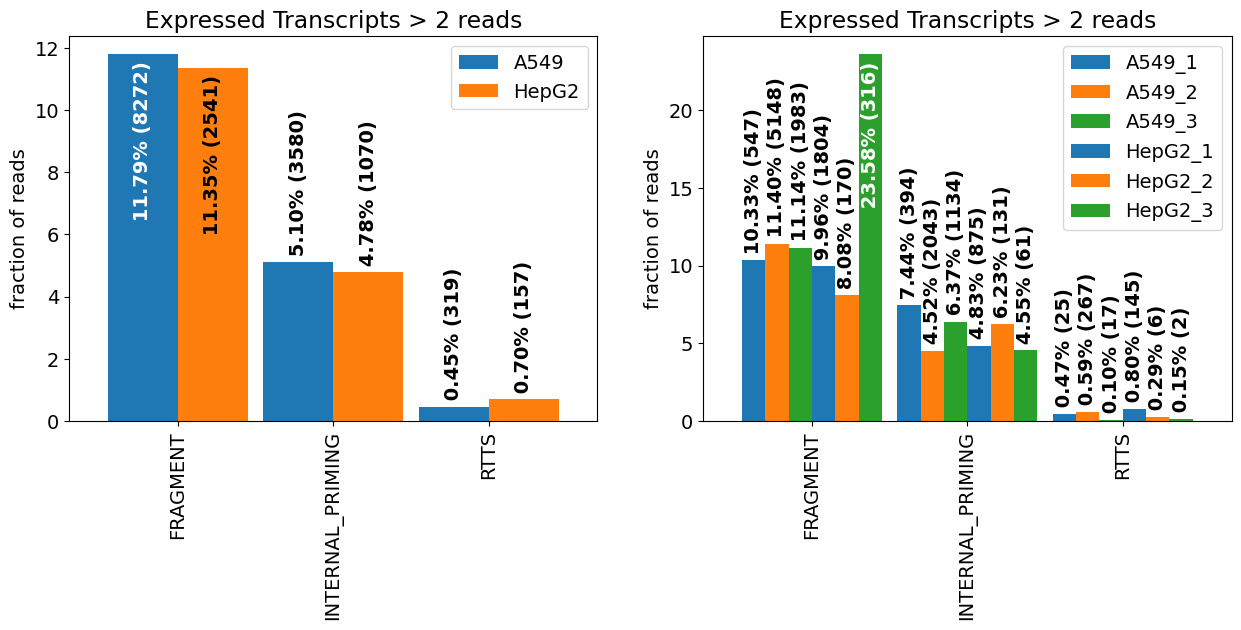

In [16]:
from isotools.plots import plot_bar

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,2)

# groupwise statistics
plot_bar(f_stats_groups[0], ax=axs[0], drop_categories=['PASS'], bar_width=.9,
         legend=True, **f_stats_groups[1])

# sample wise statistics
plot_bar(f_stats_samples[0], ax=axs[1], drop_categories=['PASS'], bar_width=.9,
         legend=True, **f_stats_samples[1])

Please note that reads will be tagged only but not removed from the analysis, as they can be informative. For instance, even if a read has been tagged as "fragment", it might present a skipping exon though it is not a full transcript. Therefore, we keep this information, and it is left to the users' judgement how to interpret the results.

### Alternative splicing events

Isotools defines alternative splicing events (ASE) with a graph based approach, including:
- Exon Skipping(ES)
- Intron Retention (IR)
- Mutually Exclusive Exons(ME)
- 3’ Alternative Splicing (3AS)
- 5’ Alternative Splicing (5AS)
- Alternative First Exons (TSS)
- Alternative Last Exons (PAS)

In [17]:
# compute the alternative splicng events
splice_events=isoseq.alternative_splicing_events()

# count the identified events by type
splice_events.splice_type.value_counts()

splice_type
TSS    230
PAS     67
5AS     44
3AS     34
ES      12
IR       9
Name: count, dtype: int64

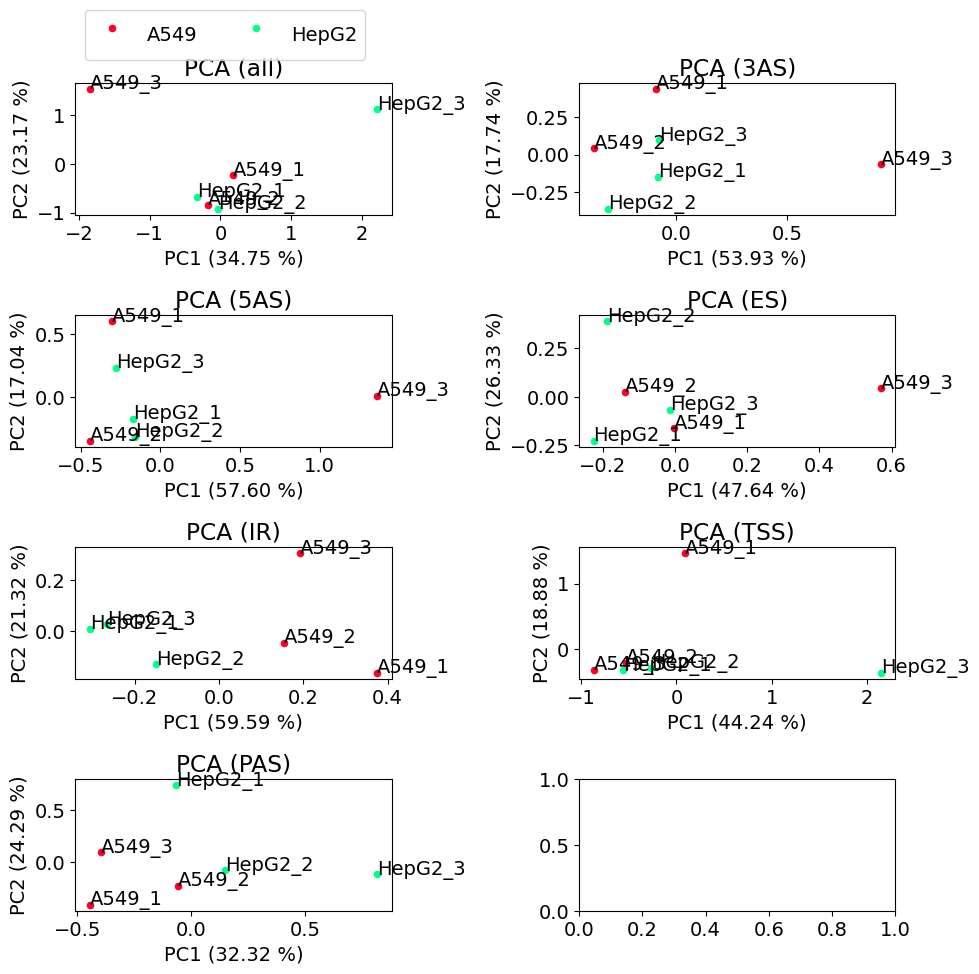

In [19]:
#plot PCA embedding

from isotools.plots import plot_embedding

plt.rcParams["figure.figsize"] = (10,10)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events,
                          ax=ax,
                          labels=True,
                          groups=isoseq.groups(),
                          splice_types=t)

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05,
                bbox_to_anchor=(0, 1.1), loc='lower left')
plt.tight_layout()

In the plot of IR, there is a nice seperation between samples from HepG2 and A549, which might indicate that IR of some genes could be tissue specific.

### Differential alternative splicing

IsoTools will focus on the most common alternative splicing events for differential analysis, including:
- Exon Skipping(ES)
- Intron Retention (IR)
- Mutually Exclusive Exons(ME)
- 3’ Alternative Splicing (3AS)
- 5’ Alternative Splicing (5AS)

In [20]:
types_of_interest=['ES','ME','5AS','3AS','IR'] #ignore alternative TSS/PAS for now

diff_splice=isoseq.altsplice_test(isoseq.groups(),
                                  types=types_of_interest,
                                  min_total=200)
diff_splice=diff_splice.sort_values('pvalue').reset_index(drop=True)
sig=diff_splice.padj<.1

n_genes=len(diff_splice.loc[sig,"gene"].unique())
print(f'{sum(sig)} differential splice sites in {n_genes} genes for '+
      " vs ".join(isoseq.groups()))
pd.set_option('display.max_columns', None)

diff_splice.head(18)
diff_splice.to_csv(f'{path}/isotools_results/demonstration_dataset_differential_events.csv',index = False)

INFO:testing differential splicing for A549 (3) vs HepG2 (3) using betabinom_lr test
100%|███████████████████████████████████| 1710/1710 [00:03<00:00, 462.06genes/s]


2 differential splice sites in 2 genes for A549 vs HepG2


In [21]:
diff_splice.head(5)

,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,trA,trB,nmdA,nmdB,A549_PSI,A549_disp,HepG2_PSI,HepG2_disp,total_PSI,total_disp,A549_1_A549_in_cov,A549_1_A549_total_cov,A549_2_A549_in_cov,A549_2_A549_total_cov,A549_3_A549_in_cov,A549_3_A549_total_cov,HepG2_1_HepG2_in_cov,HepG2_1_HepG2_total_cov,HepG2_2_HepG2_in_cov,HepG2_2_HepG2_total_cov,HepG2_3_HepG2_in_cov,HepG2_3_HepG2_total_cov
0,YDJC,ENSG00000161179,22,-,21629407,21629601,IR,False,0.071243,0.002646,"[2, 10, 15, 24, 17, 3, 41, 42, 46, 22]","[0, 12, 19, 25, 26, 6, 43, 39, 44, 27]",1.0,1.0,0.479596,0.000073,0.826863,0.000075,0.600212,0.025235,3,10,53,105,16,35,36,44,5,6,2,2
1,ST13,ENSG00000100380,22,-,40829671,40830839,3AS,True,0.071243,0.003475,"[15, 8, 62, 36, 17, 20, 52, 27, 107, 14, 134, ...","[3, 16, 6, 1, 4, 7, 23, 130, 21, 12, 5, 67, 14...",1.0,1.0,0.770082,0.080292,0.625072,0.000007,0.701845,0.060757,27,38,152,379,143,143,126,200,16,27,8,13
2,ADSL,ENSG00000239900,22,+,40361635,40362980,5AS,False,0.170959,0.013933,"[0, 30, 47, 201, 184, 213, 3, 27, 49, 71, 134,...","[1, 8, 62, 69, 29, 18, 41, 20, 73, 25, 91, 96,...",1.0,1.0,0.292960,0.111612,0.488749,0.000062,0.379458,0.088992,24,45,287,399,0,137,36,74,4,6,3,8
3,XRCC6,ENSG00000196419,22,+,41637791,41646895,5AS,True,0.170959,0.018799,"[10, 0, 31, 36, 25, 13, 28, 1, 14, 146, 268, 2...","[18, 7, 34, 15, 272, 114, 148, 315, 74, 351, 1...",1.0,1.0,0.063571,0.008381,0.103583,0.000003,0.088761,0.006750,6,87,137,1033,0,292,35,362,7,46,3,27
4,DRG1,ENSG00000185721,22,+,31400743,31403028,5AS,True,0.170959,0.022455,"[1, 3, 14, 12, 2, 4, 13, 22, 23, 24, 31, 33, 3...","[0, 53, 29, 21, 11, 15, 16, 20, 25, 26, 27, 30...",1.0,1.0,0.185509,0.049192,0.312027,0.000064,0.250452,0.037708,6,23,88,222,0,80,22,73,5,15,2,5


IsoTools has the fanctionality of visualisation with a reference gene track and long read sashimi plots for one or more samples or groups of samples. Take the top 1 gene as the example, who has a differential splicing site between two groups.

You can query the gene of interest, as the reference annotation has been imported into the IsoTools transcriptome object.

In [22]:
print(isoseq['YDJC'])

Gene YDJC 22:21628088-21630064(-), 7 reference transcripts, 51 expressed transcripts


Gene "YDJC" locates between 21628088 bp and 21630064 bp of the reverse strand on chromosome 22. There are 51 expressed transcripts and 7 out of them mapped to the genome reference.

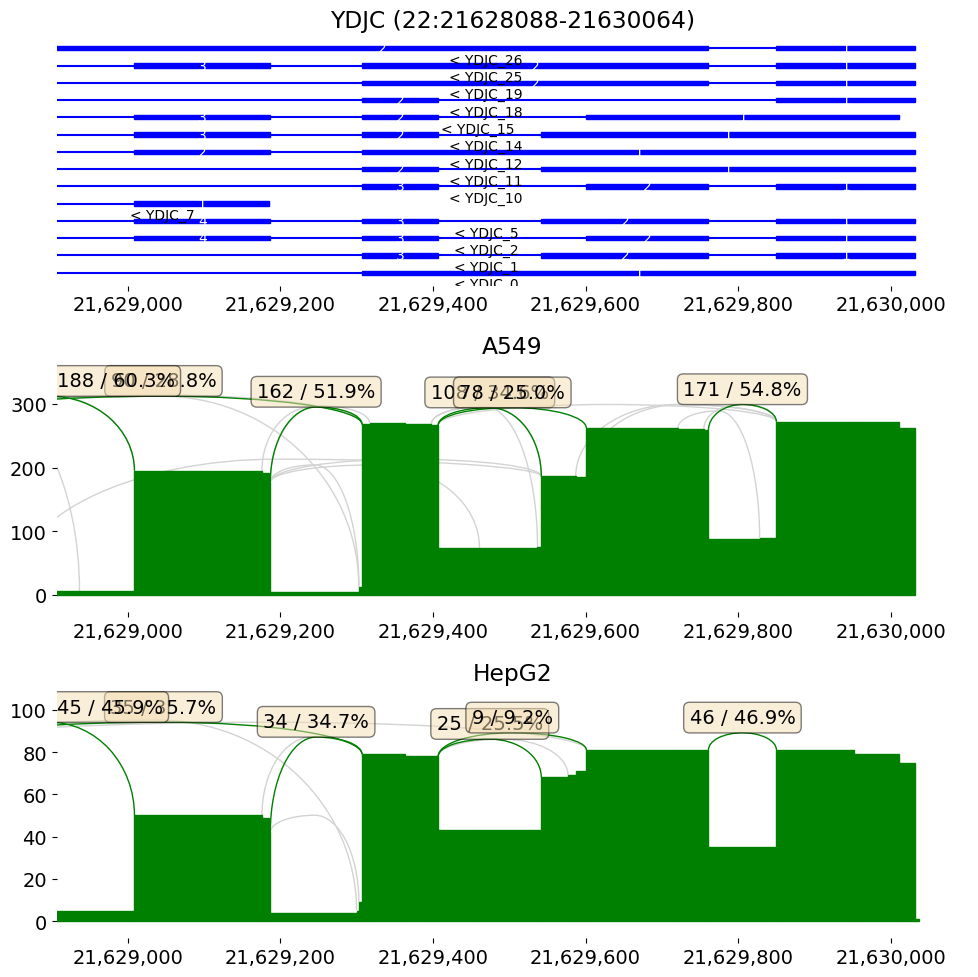

In [23]:
# visualise the differential splicing site

plt.rcParams["figure.figsize"] = (10,10)
pos=[21629407-500,21629601+500]
fig,axs=plt.subplots(3)
g=isoseq['YDJC'] # IR
g.gene_track(x_range=pos,
             ax=axs[0],
             reference=False,
             select_transcripts=g.filter_transcripts('SUBSTANTIAL'))
g.sashimi_plot(samples=isoseq.groups()['A549'],
               x_range=pos, ax=axs[1],
               title='A549',
               log_y=False)
g.sashimi_plot(samples=isoseq.groups()['HepG2'],
               x_range=pos,
               ax=axs[2],
               title='HepG2',
               log_y=False)

fig.tight_layout()

The start and end of the retained intron is between 21629407 bp and 21629601 bp. From the sashimi plot, the percentage of IR in HepG2 is higher than that in A549, which might indicate that this alternative splicing event might happen more oftern in liver comparing to lung.

## Reference

If you use IsoTools in your work, please cite the following paper:

> Matthias Lienhard et al. "IsoTools: a flexible workflow for long-read transcriptome sequencing analysis", Bioinformatics (2023). doi: <https://doi.org/10.1093/bioinformatics/btad364>

If you use the dataset from SG-NEx in your work, please cite the following paper:

> Chen, Ying, et al. “A systematic benchmark of Nanopore long read RNA sequencing for transcript level analysis in human cell lines.” bioRxiv (2021). doi: <https://doi.org/10.1101/2021.04.21.440736>